In [27]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re

file = open("/home/andres/repos/rat-mapping-paper/reports/C_SMA_LAR/combine.pkl","rb")
combinations = pickle.load(file)

In [ ]:
combinations_no_response = [(c[0], c[1], c[2]) for c in combinations]
combinations_no_response = list(set(combinations_no_response))

responses = list(set([u[3] for u in combinations.keys()]))
combinations_no_response


In [176]:
arr = None

for muscle in responses:
    arr_muscle = None

    for c in combinations_no_response:
        a = combinations[(*c, muscle)]["a"]
        a = a[:, 0, 0, 0, 0]

        if arr_muscle is None:
            arr_muscle = a[:, None]
        else:
            # concatenate now
            arr_muscle = np.concatenate([arr_muscle, a[:, None]], axis=-1)

    if arr is None:
        arr = arr_muscle[:,:, None]

    else:
        arr = np.concatenate([arr, arr_muscle[:,:, None]], axis = -1)

In [177]:
ind = []

for c in combinations_no_response:
    if c == combinations_no_response[0]: 
        ind.append(True)
    else:
        ind.append(False)

ind = np.array(ind)


In [178]:
arr[:, ind, :].shape

(4000, 1, 6)

In [93]:
ind = [
    True for u in combinations_no_response if u == combinations_no_response[0]
]


mask = np.array([bool(re.search(r'.+-.+', s[1])) for s in combinations_no_response])
filter_noGround = arr[:,mask,:]



In [94]:
filter_noGround.shape

(4000, 252, 6)

In [ ]:
# def des_pos(pos):
positions = list(set([c[1] for c in combinations_no_response]))
mask = np.array([bool("-C6R" in s[1]) for s in combinations_no_response])
pos_filt = arr[:,mask,:]
ttest_all = []
pval_all = []
m2 = []
for p in positions:
    m2 = np.array([bool(p in s[1]) for s in combinations_no_response])
    comp_filt = arr[:,m2,:]
    ttest, pval = stats.ttest_ind(pos_filt, comp_filt)
    ttest_all.append(ttest)
    pval_all.append(pval)


In [442]:
positions = list(set([c[1] for c in combinations_no_response]))
mask = np.array([bool(s[1].split("-")[0][2:] == "M" and s[1].split("-")[1][2:] == "LL") for s in combinations_no_response])
pos_filt = arr[:,mask,:]
pos_filt = pos_filt.mean(axis = 0).reshape(-1,)
ttest_all = []
pval_all = []
m2 = []

b = np.array([bool(s[2] == "B" ) for s in combinations_no_response])
s = np.array([bool(s[2] == "S" ) for s in combinations_no_response])
big = arr[:,b,:] 
small = arr[:,s,:]

for p in positions:
    m2 = np.array([bool(p in s[1]) for s in combinations_no_response])
    comp_filt = arr[:,m2,:]
    comp_filt = comp_filt.mean(axis = 0).reshape(-1,)
    ttest, pval = stats.ttest_ind(pos_filt, comp_filt)
    ttest_all.append(ttest)
    pval_all.append(pval)

In [192]:
dictBool = {}

dictBool[('LL', 'S')] = np.array([bool(re.search(r'.+-', s[1]) and s[1].split("-")[1][2:] == "LL" and s[2] == "S") for s in combinations_no_response])
dictBool[('L', 'S')]  = np.array([bool(re.search(r'.+-', s[1]) and s[1].split("-")[1][2:] == "L" and s[2] == "S") for s in combinations_no_response])
dictBool[('LM1', 'S')]  = np.array([bool(re.search(r'.+-', s[1]) and s[1].split("-")[1][2:] == "LM1" and s[2] == "S") for s in combinations_no_response])
dictBool[('LM2', 'S')]  = np.array([bool(re.search(r'.+-', s[1]) and s[1].split("-")[1][2:] == "LM2" and s[2] == "S") for s in combinations_no_response])
dictBool[('M', 'S')]  = np.array([bool(re.search(r'.+-', s[1]) and s[1].split("-")[1][2:] == "M" and s[2] == "S") for s in combinations_no_response])
dictBool[('LL', 'B')]  = np.array([bool(re.search(r'.+-', s[1]) and s[1].split("-")[1][2:] == "LL" and s[2] == "B") for s in combinations_no_response])
dictBool[('L', 'B')] = np.array([bool(re.search(r'.+-', s[1]) and s[1].split("-")[1][2:] == "L" and s[2] == "B") for s in combinations_no_response])
dictBool[('LM', 'B')] = np.array([bool(re.search(r'.+-', s[1]) and s[1].split("-")[1][2:] == "LM" and s[2] == "B") for s in combinations_no_response])
dictBool[('M', 'B')] = np.array([bool(re.search(r'.+-', s[1]) and s[1].split("-")[1][2:] == "M" and s[2] == "B") for s in combinations_no_response])


In [419]:
#BIG V SMALL

def bvs(pos, which):
    for k,v in dictBool.items():
        value = []
        if pos == "LM1" and k[0] == pos:
                S = arr[:,v,:].mean(axis = 0).reshape(-1,)
                for k1, v1 in dictBool.items():
                    if k1[1] == "B" and k1[0] == "LM":
                        B = arr[:,v1,:].mean(axis = 0).reshape(-1,)
                        tbvs, pbvs = stats.ttest_ind(B,S, alternative="less")
                        if pbvs < 0.05:
                            value.append(f"{k1} is more effective than {k} (p = {pbvs})")
                        else: value.append(f"No significant difference for {k1} vs {k} (p = {pbvs})")
                    else: pass
                return value
        
        elif which == "S":
            if k[0] == pos and k[1] == which:
                tar = arr[:,v,:]
                for k1,v1 in dictBool.items():
                    if k1[0] != pos and k1[1] == which:
                        a1 = arr[:,v,:].mean(axis = 0).reshape(-1,)
                        a2 = arr[:,v1,:] .mean(axis = 0).reshape(-1,)
                        tbvs, pbvs = stats.ttest_ind(a1,a2, alternative="less")
                        if pbvs < 0.05:
                            value.append(f"{k} is more effective than {k1} (p = {pbvs})")
                        else: value.append(f"No significant difference for {k} vs {k1} (p = {pbvs})")
                return value

        if which == "B":
            if k[0] == pos and k[1] == which:
                tar = arr[:,v,:]
                for k1,v1 in dictBool.items():
                    if k1[0] != pos and k1[1] == "B":
                        a1 = arr[:,v,:].mean(axis = 0).reshape(-1,)
                        a2 = arr[:,v1,:] .mean(axis = 0).reshape(-1,)
                        tbvs, pbvs = stats.ttest_ind(a1,a2, alternative="less")
                        if pbvs < 0.05:
                            value.append(f"{k} is more effective than {k1} (p = {pbvs})")
                        else: value.append(f"No significant difference for {k} vs {k1} (p = {pbvs})")            
                return value
        

        if which == "C" and k[0] == pos and k[1] == "B":
            B = arr[:,v,:].mean(axis = 0).reshape(-1,)
                
            for k1, v1 in dictBool.items():
                if k1[1] == "S" and k1[0] == pos:
                    S = arr[:,v1,:].mean(axis = 0).reshape(-1,)
                    tbvs, pbvs = stats.ttest_ind(B,S, alternative="less")
                    if pbvs < 0.05:
                        value.append(f"{k} is more effective than {k1} (p = {pbvs})")
                    else: value.append(f"No significant difference for {k} vs {k1} (p = {pbvs})")
                else: pass
            return value

    return value
        


In [332]:
#this is one sided t test
a = bvs('LL', 'S')
a

["No significant difference for ('LL', 'S') vs ('L', 'S') (p = 0.9912744707455274)",
 "No significant difference for ('LL', 'S') vs ('LM1', 'S') (p = 0.6438061648748665)",
 "No significant difference for ('LL', 'S') vs ('LM2', 'S') (p = 0.4888663387867556)",
 "No significant difference for ('LL', 'S') vs ('M', 'S') (p = 0.8684579070636069)"]

In [423]:
p = [p[0] for p in dictBool.keys()]
mydict = {}

for val in p:
    small = bvs(val, "S")
    big = bvs(val,"B")
    mydict[val, "S"] = small
    mydict[val, "B"] = big
    combo = bvs(val,"C")
    mydict[val, "Big vs Small"] = combo


In [371]:
mydict.keys()

dict_keys([('LL', 'S'), ('LL', 'B'), ('LL', 'Big vs Small'), ('L', 'S'), ('L', 'B'), ('L', 'Big vs Small'), ('LM1', 'S'), ('LM1', 'B'), ('LM1', 'Big vs Small'), ('LM2', 'S'), ('LM2', 'B'), ('LM2', 'Big vs Small'), ('M', 'S'), ('M', 'B'), ('M', 'Big vs Small'), ('LM', 'S'), ('LM', 'B'), ('LM', 'Big vs Small')])

In [424]:
for k,v in dictBool.items():
    if k[0] == "LL" and k[1] == "S":
        tar = arr[:,v,:]
        for k1,v1 in dictBool.items():
            if k1[0] != "LL" and k1[1] == "S":
                a1 = arr[:,v,:].mean(axis = 0).reshape(-1,)
                a2 = arr[:,v1,:] .mean(axis = 0).reshape(-1,)
                tbvs, pbvs = stats.ttest_ind(a1,a2, alternative="less")
                print(f"The p value for {k} vs {k1} is {pbvs}")
    else: pass

The p value for ('LL', 'S') vs ('L', 'S') is 0.9912744707455274
The p value for ('LL', 'S') vs ('LM1', 'S') is 0.6438061648748665
The p value for ('LL', 'S') vs ('LM2', 'S') is 0.4888663387867556
The p value for ('LL', 'S') vs ('M', 'S') is 0.8684579070636069


In [425]:
def filter_dict_by_strings(data, search_string):
    # Create a new dictionary to store the filtered results
    if not isinstance(data, dict):
        raise ValueError("Input data should be a dictionary.")
    
    filtered_dict = {}
    
    # Iterate over each key-value pair in the original dictionary
    for key, value_list in data.items():
        if not isinstance(value_list, list):
            print(f"Skipping key '{key}' because the value is not a list.")
            continue
        # Filter the value list for the search strings
        filtered_values = [item for item in value_list if search_string in item]
        
        # Add the filtered values to the new dictionary if not empty
        if filtered_values:
            filtered_dict[key] = filtered_values
    
    return filtered_dict

a = filter_dict_by_strings(mydict, "effective")   

In [383]:
b = bvs('LM1', 'S')


In [426]:
a

{('LL',
  'Big vs Small'): ["('LL', 'B') is more effective than ('LL', 'S') (p = 1.502948464049102e-07)"],
 ('L',
  'S'): ["('L', 'S') is more effective than ('LL', 'S') (p = 0.00872552925447256)", "('L', 'S') is more effective than ('LM1', 'S') (p = 0.04548015503051278)"],
 ('L',
  'B'): ["('L', 'B') is more effective than ('LL', 'B') (p = 0.001596414263979888)", "('L', 'B') is more effective than ('LM', 'B') (p = 0.0029806019290330226)"],
 ('L',
  'Big vs Small'): ["('L', 'B') is more effective than ('L', 'S') (p = 1.0939669470057542e-09)"],
 ('LM1',
  'S'): ["('LM', 'B') is more effective than ('LM1', 'S') (p = 0.0016625618682520119)"],
 ('LM1',
  'B'): ["('LM', 'B') is more effective than ('LM1', 'S') (p = 0.0016625618682520119)"],
 ('LM1',
  'Big vs Small'): ["('LM', 'B') is more effective than ('LM1', 'S') (p = 0.0016625618682520119)"],
 ('M',
  'B'): ["('M', 'B') is more effective than ('LL', 'B') (p = 0.033165682367399016)", "('M', 'B') is more effective than ('LM', 'B') (p = 0

In [389]:
a

{('LL',
  'Big vs Small'): ["('LL', 'B') is more effective than ('LL', 'S') (p = 1.502948464049102e-07)"],
 ('L',
  'S'): ["('L', 'S') is more effective than ('LL', 'S') (p = 0.00872552925447256)", "('L', 'S') is more effective than ('LM1', 'S') (p = 0.04548015503051278)"],
 ('L',
  'B'): ["('L', 'B') is more effective than ('LL', 'B') (p = 0.001596414263979888)", "('L', 'B') is more effective than ('LM', 'B') (p = 0.0029806019290330226)"],
 ('L',
  'Big vs Small'): ["('L', 'B') is more effective than ('L', 'S') (p = 1.0939669470057542e-09)"],
 ('LM1',
  'S'): ["('LM1', 'S') is more effective than ('LM', 'B') (p = 0.0016625618682520119)"],
 ('LM1',
  'B'): ["('LM1', 'S') is more effective than ('LM', 'B') (p = 0.0016625618682520119)"],
 ('LM1',
  'Big vs Small'): ["('LM1', 'S') is more effective than ('LM', 'B') (p = 0.0016625618682520119)"],
 ('M',
  'B'): ["('M', 'B') is more effective than ('LL', 'B') (p = 0.033165682367399016)", "('M', 'B') is more effective than ('LM', 'B') (p = 0

In [395]:
dictBool.keys()

dict_keys([('LL', 'S'), ('L', 'S'), ('LM1', 'S'), ('LM2', 'S'), ('M', 'S'), ('LL', 'B'), ('L', 'B'), ('LM', 'B'), ('M', 'B')])

In [402]:
left, right = ('LM1', 'S'), ('LM', 'B')
left, right = dictBool[left], dictBool[right]

left, right = arr[:, left, ...], arr[:, right, ...]

print(left.shape)
print(right.shape)


(4000, 26, 6)
(4000, 6, 6)


In [403]:
left = left.mean(axis=0).reshape(-1,)
right = right.mean(axis=0).reshape(-1,)


<function scipy.stats._stats_py.ttest_1samp(a, popmean, axis=0, nan_policy='propagate', alternative='two-sided', *, keepdims=False)>

In [407]:
stats.ttest_ind(left, right, alternative="greater")

TtestResult(statistic=2.9735651994417744, pvalue=0.0016625618682520119, df=190.0)

In [428]:
left, right = ('LM1', 'S'), ('LM', 'B')
left, right = dictBool[left], dictBool[right]

combinations_no_response


[('amap03', '-C6LM2', 'S'),
 ('amap07', 'C6R-C6RR', 'B'),
 ('amap06', 'C6RM-C6R', 'B'),
 ('amap04', 'C6R-C6RR', 'B'),
 ('amap05', '-C6M', 'B'),
 ('amap05', '-C5LL', 'S'),
 ('amap07', 'C6M-C6RR', 'B'),
 ('amap02', '-C7R', 'B'),
 ('amap03', 'C6M-C6L', 'B'),
 ('amap07', 'C6RM-C6RR', 'B'),
 ('amap08', 'C5LM2-C5LL', 'S'),
 ('amap04', '-C6M', 'S'),
 ('amap04', 'C6RM-C6RR', 'B'),
 ('amap02', 'C7LM-C7M', 'B'),
 ('amap03', '-C6L', 'S'),
 ('amap03', '-C5LM1', 'S'),
 ('amap07', 'C5LM1-C5L', 'S'),
 ('amap04', 'C5LM1-C5L', 'S'),
 ('amap04', 'C6M-C6R', 'B'),
 ('amap02', '-C7RM', 'B'),
 ('amap06', '-C6M', 'B'),
 ('amap03', '-C5LM2', 'S'),
 ('amap08', '-C5LL', 'B'),
 ('amap06', 'C5LM2-C5LL', 'S'),
 ('amap08', '-C5L', 'B'),
 ('amap07', 'C6LM-C6LL', 'B'),
 ('amap02', 'C6LL-C6L', 'B'),
 ('amap08', '-C6LM', 'B'),
 ('amap08', '-C5LM2', 'S'),
 ('amap02', 'C5LM1-C5LL', 'S'),
 ('amap02', 'C5LM2-C6LL', 'S-B'),
 ('amap03', 'C5L-C5LL', 'S'),
 ('amap02', 'C5M-C5LL', 'B'),
 ('amap04', '-C5LM1', 'S'),
 ('amap05', '

In [ ]:
[u for u, b in zip(combinations_no_response, left) if b]

# Lateral vs Medial

In [449]:
dictBool = {}

dictBool[('M-LL', 'S')] = np.array([bool(s[1].split("-")[0][2:] == "M" and s[1].split("-")[1][2:] == "LL" and s[2] == "S") for s in combinations_no_response])
dictBool[('M-L', 'S')]  = np.array([bool(s[1].split("-")[0][2:] == "M" and s[1].split("-")[1][2:] == "L" and s[2] == "S") for s in combinations_no_response])
dictBool[('M-LM1', 'S')]  = np.array([bool(s[1].split("-")[0][2:] == "M" and s[1].split("-")[1][2:] == "LM1" and s[2] == "S") for s in combinations_no_response])
dictBool[('M-LM2', 'S')]  = np.array([bool(s[1].split("-")[0][2:] == "M" and s[1].split("-")[1][2:] == "LM2" and s[2] == "S") for s in combinations_no_response])
dictBool[('M-M', 'S')]  = np.array([bool(s[1].split("-")[0][2:] == "M" and s[1].split("-")[1][2:] == "M" and s[2] == "S") for s in combinations_no_response])
dictBool[('M-LL', 'B')]  = np.array([bool(s[1].split("-")[0][2:] == "M" and s[1].split("-")[1][2:] == "LL" and s[2] == "B") for s in combinations_no_response])
dictBool[('M-L', 'B')] = np.array([bool(s[1].split("-")[0][2:] == "M" and s[1].split("-")[1][2:] == "L" and s[2] == "B") for s in combinations_no_response])
dictBool[('M-LM', 'B')] = np.array([bool(s[1].split("-")[0][2:] == "M" and s[1].split("-")[1][2:] == "LM" and s[2] == "B") for s in combinations_no_response])
dictBool[('M-M', 'B')] = np.array([bool(s[1].split("-")[0][2:] == "M" and s[1].split("-")[1][2:] == "M" and s[2] == "B") for s in combinations_no_response])

In [450]:
p = [p[0] for p in dictBool.keys()]
lvm = {}

for val in p:
    small = bvs(val, "S")
    big = bvs(val,"B")
    lvm[val, "S"] = small
    lvm[val, "B"] = big
    combo = bvs(val,"C")
    lvm[val, "Big vs Small"] = combo


lvm = filter_dict_by_strings(lvm, "effective")
lvm


{('M-LL',
  'Big vs Small'): ["('M-LL', 'B') is more effective than ('M-LL', 'S') (p = 0.0038092487500114634)"],
 ('M-L',
  'B'): ["('M-L', 'B') is more effective than ('M-LL', 'B') (p = 0.0002966804667118571)", "('M-L', 'B') is more effective than ('M-LM', 'B') (p = 0.0022280145873721817)"],
 ('M-L',
  'Big vs Small'): ["('M-L', 'B') is more effective than ('M-L', 'S') (p = 1.8820580235937052e-08)"]}

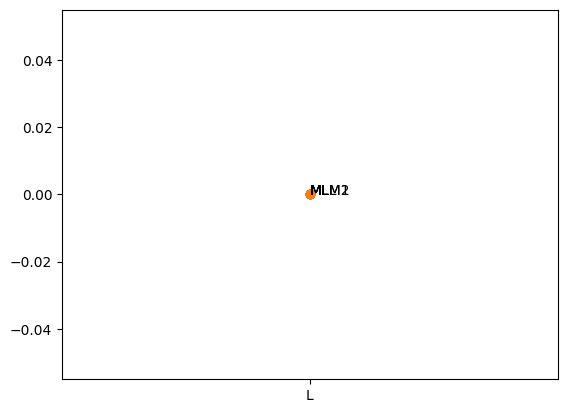

In [521]:
target = {}
MLL= arr[:, dictBool[(('M-LL', 'S'))], ...].mean(axis = 0).reshape(-1,)
MLM1 = arr[:, dictBool[(('M-LM1', 'S'))], ...].mean(axis = 0).reshape(-1,)
MLM2 = arr[:, dictBool[(('M-LM2', 'S'))], ...].mean(axis = 0).reshape(-1,)
ML = arr[:, dictBool[(('M-L', 'S'))], ...].mean(axis = 0).reshape(-1,)
target.update({'MLL':MLL, 'ML':ML, 'MLM1':MLM1,'MLM2':MLM2})


val = [c[1] for c in target]
y=[0,0,0,0]


fig, ax = plt.subplots()

ax.scatter(val, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (val[i], y[i]))
plt.scatter(val,y)



In [511]:
[u for u, b in zip(combinations_no_response, dictBool[('M-L', 'S')]) if b]

[('amap07', 'C5M-C5L', 'S'),
 ('amap06', 'C6M-C6L', 'S'),
 ('amap08', 'C5M-C5L', 'S'),
 ('amap05', 'C6M-C6L', 'S'),
 ('amap06', 'C5M-C5L', 'S'),
 ('amap03', 'C6M-C6L', 'S'),
 ('amap04', 'C6M-C6L', 'S'),
 ('amap05', 'C5M-C5L', 'S'),
 ('amap04', 'C5M-C5L', 'S'),
 ('amap07', 'C6M-C6L', 'S'),
 ('amap08', 'C6M-C6L', 'S'),
 ('amap03', 'C5M-C5L', 'S')]

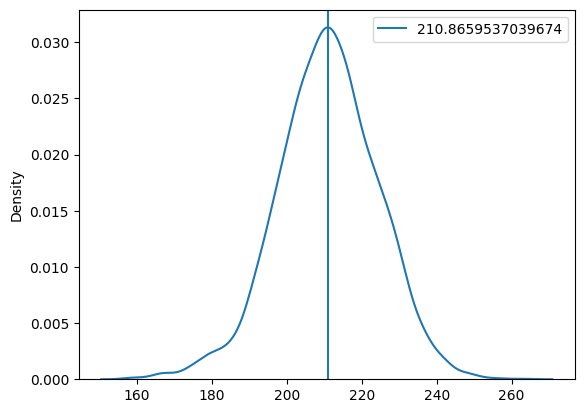

In [530]:
ind = dictBool[('M-L', 'S')]
t = (arr[:, ind, ...])
samples = t.mean(axis=(-1, -2))
sns.kdeplot(samples)
plt.axvline(samples.mean(), label=f"{samples.mean()}")
plt.legend()

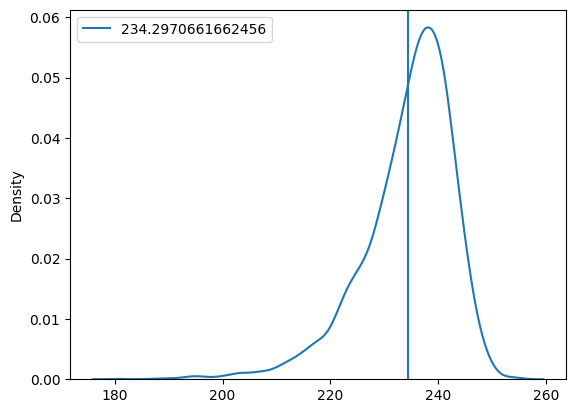

In [529]:
ind = dictBool[('M-LL', 'S')]
t = (arr[:, ind, ...])
samples = t.mean(axis=(-1, -2))
sns.kdeplot(samples)
plt.axvline(samples.mean(), label=f"{samples.mean()}")
plt.legend()


In [ ]:
ind = dictBool[('M-L', 'S')]
t = (arr[:, ind, ...])
samples = t.mean(axis=(-1, -2))
sns.kdeplot(samples)
plt.axvline(samples.mean(), label=f"{samples.mean()}")
plt.legend()

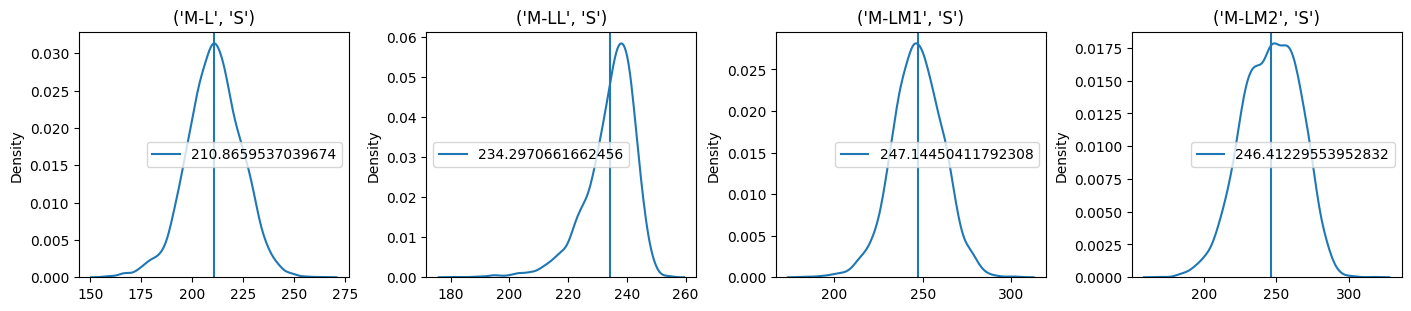

In [535]:
nrows, ncols = 1, 4
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(14, 3),
    constrained_layout=True,
    squeeze=False
)

for i, alignment in enumerate(["M-L", "M-LL", "M-LM1", "M-LM2"]):
    ax = axes[0, i]

    ind = dictBool[(alignment, 'S')]
    t = (arr[:, ind, ...])
    samples = t.mean(axis=(-1, -2))
    sns.kdeplot(samples, ax=ax)
    ax.axvline(samples.mean(), label=f"{samples.mean()}")
    ax.legend()
    ax.set_title((alignment, 'S'))

